# Vectorizacion de texto

# MODELO 1.

In [37]:
#  TOPIC MODELING
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import json
import glob
import re
from pprint import pprint

def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = pd.read_csv(f)
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)


In [2]:
def remove_stops(text, stops):
    text = re.sub(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+','',text)
    text = re.sub(r'[^\w\s -]','',text)
    text = re.sub(r'-',' ',text)
    text = text.lower()
    words = text.split()
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
    final = " ".join(final)
    final = final.translate(str.maketrans("", "", string.punctuation))
    final = "".join([i for i in final if not i.isdigit()])
    while "  " in final:
        final = final.replace("  ", " ")
    return (final)

def clean_docs(docs):
    stops = stopwords.words("spanish")
    final = []
    for doc in docs:
        #clean_doc = remove_stops(doc, stops)
        final.append(doc)
    return (final)

In [78]:
encontrado = load_data("titulosEncontrados.csv")
candidato = load_data("titulosCandidatos.csv")
# print (descriptions[0])
candidato = candidato.dropna()
encontrado = encontrado.dropna()
titEncontrado = clean_docs(encontrado['titulo'])
titCandidato = clean_docs(candidato['titulo'])
# print (cleaned_docs[0])


In [4]:
dfTitCandidato = pd.read_csv('df_titulosCandidatos.csv', sep=',',  encoding='utf-8')
dfTitEncontrado = pd.read_csv('df_titulosEncontrados.csv', sep=',',  encoding='utf-8')

In [5]:
stops = stopwords.words("spanish")

vectorizer = TfidfVectorizer(
                                lowercase=False,
                                use_idf=True,
                                max_features=20000,
                                max_df=0.99,
                                min_df=50,
                                ngram_range = (1,3),
                                stop_words = stops
                                

                            )

vectorizer.fit(titEncontrado)
vectorsCandidatos = vectorizer.transform(titCandidato)
vectorsEncontrado = vectorizer.transform(titEncontrado)
feature_names = vectorizer.get_feature_names_out()




In [6]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(vectorsCandidatos, vectorsEncontrado)

In [7]:
dist.shape

(13250, 5286)

In [8]:
import seaborn as sns
import numpy as np

result = np.where(dist > 0.8)  #buscar como se utiliza


In [9]:
#sns.heatmap(htm)

In [11]:
true_k = 20

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

model.fit(vectorsEncontrado)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

with open ("clusters_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")

In [12]:
#terms

## CountVectorizer

In [181]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

encontrado = load_data("titulosEncontrados.csv")['titulo']
coun_vect = CountVectorizer(ngram_range=(1,3),max_features = 30)
coun_vect.fit(titEncontrado)
count_candidatos = coun_vect.transform(titCandidato)
count_encontrados = coun_vect.transform(titEncontrado)
count_array = count_candidatos.toarray()
dfCountVec = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out())
dfCountVec

,actor,antecedentes,antecedentes autos,antecedentes autos interes,autos,autos interes,clinica,conclusiones,consideraciones,consideraciones medico,...,interes medico legal,legal,legales,medico,medico legal,medico legales,pericia,petitorio,puntos,puntos pericia
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
print(coun_vect.vocabulary_)

{'antecedentes': 1, 'interes': 14, 'medico': 18, 'legal': 16, 'interes medico': 15, 'medico legal': 19, 'examen': 11, 'actor': 0, 'consideraciones': 6, 'legales': 17, 'consideraciones medico': 7, 'medico legales': 20, 'consideraciones medico legales': 8, 'conclusiones': 5, 'contestacion': 9, 'puntos': 23, 'pericia': 21, 'contestacion puntos': 10, 'puntos pericia': 24, 'petitorio': 22, 'autos': 3, 'historia': 12, 'clinica': 4, 'historia clinica': 13, 'antecedentes autos': 2}


In [15]:
print(coun_vect.get_feature_names_out())

['actor' 'antecedentes' 'antecedentes autos' 'autos' 'clinica'
 'conclusiones' 'consideraciones' 'consideraciones medico'
 'consideraciones medico legales' 'contestacion' 'contestacion puntos'
 'examen' 'historia' 'historia clinica' 'interes' 'interes medico' 'legal'
 'legales' 'medico' 'medico legal' 'medico legales' 'pericia' 'petitorio'
 'puntos' 'puntos pericia']


In [16]:
coun_vect.get_feature_names_out()

array(['actor', 'antecedentes', 'antecedentes autos', 'autos', 'clinica',
       'conclusiones', 'consideraciones', 'consideraciones medico',
       'consideraciones medico legales', 'contestacion',
       'contestacion puntos', 'examen', 'historia', 'historia clinica',
       'interes', 'interes medico', 'legal', 'legales', 'medico',
       'medico legal', 'medico legales', 'pericia', 'petitorio', 'puntos',
       'puntos pericia'], dtype=object)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(count_candidatos, count_encontrados)

In [18]:
dist.shape

(13250, 5286)

In [52]:
def buscartitulo(tituloE, tituloC):
    titEncontrados = []
    for titulo in tituloE:
        for candidato in tituloC:
            if titulo == candidato:
                titEncontrados.append(candidato)
    return titEncontrados

    

In [221]:
encontradosTokens = encontrado.value_counts().head(100)

In [275]:
candidatoToken = candidato.value_counts().head(500)

In [276]:
def listartitulos(tokens):
    listTit=[]
    for i,j in tokens.items():
        i = remove_stops(str(i),stops)
        listTit.append(i)
    return listTit

In [277]:
candidatosList = listartitulos(candidatoToken)
encontradosList = listartitulos(encontradosTokens)

In [278]:
candidatosEncontrados = buscartitulo(encontradosList, candidatosList)

In [279]:
candidatosEncontrados

['petitorio',
 'conclusiones',
 'consideraciones medico legales',
 'antecedentes autos interes medico legal',
 'contestacion puntos pericia',
 'hechos',
 'conclusiones medico legales',
 'objeto',
 'consideraciones medicolegales',
 'datos personales',
 'examen actor',
 'examen fisico',
 'antecedentes autos',
 'bibliografia',
 'estudios complementarios',
 'respuesta puntos pericia',
 'puntos periciales',
 'puntos pericia',
 'antecedentes',
 'incapacidad',
 'examen actora',
 'examen medico legal',
 'identificacion actor',
 'antecedentes laborales',
 'columna cervical',
 'conclusiones medicolegales',
 'columna lumbosacra',
 'historia clinica actual',
 'relato hechos',
 'conclusion',
 'constancias autos',
 'medico',
 'incapacidad actual',
 'antecedentes personales']

<AxesSubplot:>

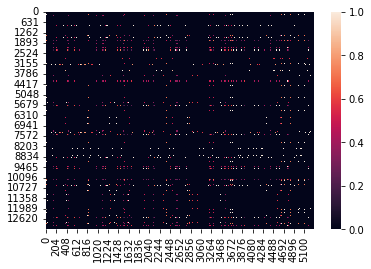

In [24]:
import seaborn as sns
import numpy as np

sns.heatmap(dist)

In [29]:
dist.shape

(13250, 5286)

In [166]:
import numpy
numpy.argmax(dist[0])


30

In [168]:
dist[0][30]

0.7071067811865475

In [177]:
count_array[30]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [178]:
coun_vect.get_feature_names_out()

array(['actor', 'antecedentes', 'antecedentes autos', 'autos', 'clinica',
       'conclusiones', 'consideraciones', 'consideraciones medico',
       'consideraciones medico legales', 'contestacion',
       'contestacion puntos', 'examen', 'historia', 'historia clinica',
       'interes', 'interes medico', 'legal', 'legales', 'medico',
       'medico legal', 'medico legales', 'pericia', 'petitorio', 'puntos',
       'puntos pericia'], dtype=object)

In [280]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
#prueba de vectorizador
coun_vect = CountVectorizer(ngram_range=(1,4),max_features = 100)
coun_vect.fit(encontradosList)
countV_candidatos = coun_vect.transform(candidatosList)
countV_encontrados = coun_vect.transform(encontradosList)
count_array = countV_candidatos.toarray()
dfCountVec = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out())

In [281]:
dfCountVec

,actor,actora,actual,analizada,antecedentes,antecedentes autos,antecedentes autos interes,antecedentes autos interes medico,antecedentes personales,autos,...,recomendaciones,relato,relato hechos,respiratorio,respuesta,respuesta puntos,respuesta puntos pericia,solicitados,tecnicas,utilizados
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [282]:
from sklearn.metrics.pairwise import cosine_similarity
distPrueba = cosine_similarity(countV_candidatos, countV_encontrados)

In [283]:
distPrueba.shape

(500, 100)

<AxesSubplot:>

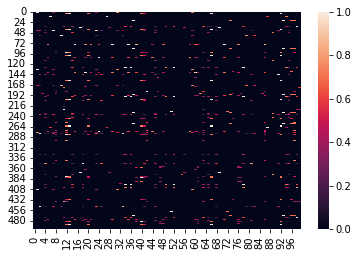

In [284]:
sns.heatmap(distPrueba)

In [290]:
import numpy
numpy.argmax(distPrueba, axis=1)

array([19,  2,  1,  0, 13,  0,  0,  0,  0,  0,  0,  6, 17,  0,  0,  0,  0,
        0,  0,  0, 37, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       98,  0, 17,  0,  0, 75,  0, 13, 98,  7,  0,  0,  0,  0, 89,  0,  0,
       13,  0, 13, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25,
        0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0, 51,  0, 12,  0, 46, 37,
        4,  0,  0, 13,  0,  0,  0, 59, 14, 12, 22,  0,  0,  0, 18, 13,  0,
       13,  0,  0, 24,  0,  0,  0,  0,  0,  0, 89,  0,  0, 60,  0,  0,  0,
        0,  0,  0,  0,  0, 12,  0,  0, 91, 34,  0,  0, 51, 11,  1, 15,  0,
        0, 96,  0, 65, 19, 37,  0,  0, 91, 25,  0, 17,  0,  0,  0, 46, 91,
        0, 96,  0,  0,  0, 13,  0,  0, 24,  0,  0, 62,  0,  0,  0,  0, 10,
       54,  0, 19,  0, 11,  3,  0,  0,  0,  0,  0,  0,  0, 42,  0,  0,  0,
       82, 62,  0, 37,  0, 15, 13,  0, 34,  0,  0,  0,  0, 13,  0, 13, 76,
       25, 46,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,
       89,  0,  0, 76, 11

In [296]:
ind = np.unravel_index(np.argmax(distPrueba, axis=None), distPrueba.shape)

In [297]:
distPrueba[ind]

1.0000000000000002

In [298]:
index_array = np.argmax(distPrueba, axis=-1)
np.take_along_axis(distPrueba, np.expand_dims(index_array, axis=-1), axis=-1)

array([[0.40824829],
       [1.        ],
       [1.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.57735027],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.57735027],
       [0.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [287]:
distanciaCoseno=[]
for e in countV_encontrados:
   m=-1
   ind=0
   for c in countV_candidatos:
      
      
      if (cosine_similarity(c,e)) > m:
         m=(cosine_similarity(c,e))
         ind=c.indices
         #pprint(cosine_similarity(c,e))
      arreglo=(ind,m)
   distanciaCoseno.append(arreglo)


In [288]:
distanciaCoseno

[(array([94]), array([[0.]])),
 (array([17]), array([[1.]])),
 (array([20, 21, 22, 52, 68, 71]), array([[1.]])),
 (array([14, 36, 37]), array([[1.]])),
 (array([ 4,  5,  6,  7,  9, 10, 11, 47, 48, 49, 51, 68, 69]), array([[1.]])),
 (array([25, 26, 27, 82, 87, 88]), array([[1.]])),
 (array([35]), array([[1.]])),
 (array([17, 18, 19, 52, 68, 71]), array([[1.]])),
 (array([14, 36, 37]), array([[0.8660254]])),
 (array([94]), array([[0.]])),
 (array([20, 23, 73]), array([[1.]])),
 (array([28, 84]), array([[1.]])),
 (array([ 0, 34]), array([[1.]])),
 (array([34]), array([[1.]])),
 (array([4, 5, 9]), array([[1.]])),
 (array([82, 87, 88]), array([[1.]])),
 (array([94]), array([[0.]])),
 (array([16, 32, 33]), array([[1.]])),
 (array([ 4, 47, 48, 49, 51, 68, 69]), array([[1.]])),
 (array([82, 87, 88, 94, 95, 96]), array([[1.]])),
 (array([34]), array([[0.70710678]])),
 (array([25, 26, 27, 82, 87, 88]), array([[0.9258201]])),
 (array([98]), array([[1.]])),
 (array([17, 18, 19, 52, 68, 71]), array